# Model comparison using Bayesian evidence
In this notebook, we compare models for a generated data trajectory.
We are given a trajectory of a SEIR model and fit this data with both a SEIR as well as a simpler SIR model.
We compare these models by computing their Bayesian evidence.

Pyross supports three ways of computing the evidence.
 * **Nested sampling:** This method is implemented directly in `pyross.inference`. 
     Nested sampling can be used to sample the posterior, but the algorithm is designed for estimating evidences.
     This is typically the fastest method in small dimensions but tends to become very slow for complex problems.
     We use the [dynesty](https://github.com/joshspeagle/dynesty/) Python package as the implementation of nested sampling.
 * **Sequential Monte Carlo:** This method is implemented in `pyross.evidence`. 
     We implement the SMC2 algorithm described in [[Zhou, Johansen, Aston 2016]](https://doi.org/10.1080/10618600.2015.1060885).
     This method works by transitioning a set of particles from the prior to the posterior.
     The transition steps are chosen adaptively which makes this method easy to use.
     However, once a result has been computed, it cannot be extended so one typically has to run the algorithm multiple times to determine the accuracy of the result.
     This method should work whenever MCMC sampling of the posterior is feasible.
 * **Path sampling/Thermodynamic integration:** This method is implemented in `pyross.evidence`.
     To compute the evidence, we estimate the expectation of the log-likelihood on a geometric transition path between the prior and the posterior.
     Unlike SMC, the steps of this transition are not chosen adaptively, but any run can be extended by continue running individual MCMC chains or increasing the number of steps.
     This method should work whenever MCMC sampling of the posterior is feasible.
     
Note that since some of the evidence algorithms are quite slow, this notebook has a very long run time.

In [1]:
%env OMP_NUM_THREADS=1
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

env: OMP_NUM_THREADS=1


## 1) Generate a trajectory from the SEIR model
We generate a test trajectory on a population with two ages groups.

In [2]:
np.random.seed(1)
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([1, 1])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa, 'seed':2}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

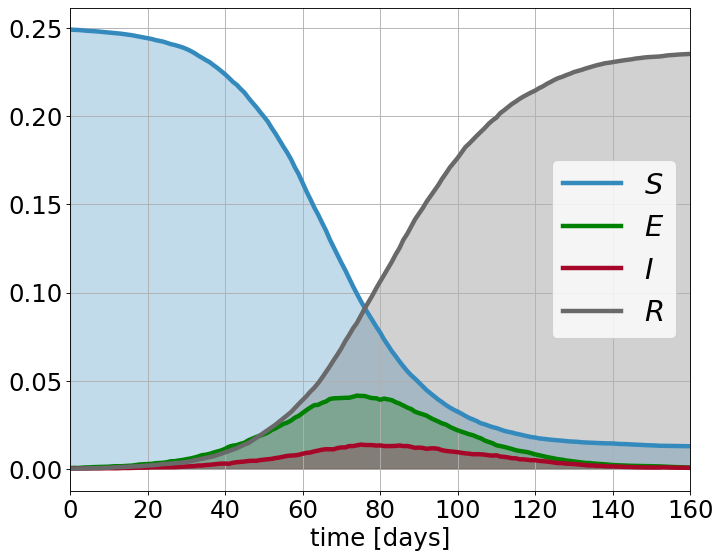

In [3]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Compute the model evidence for the SEIR model
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory.

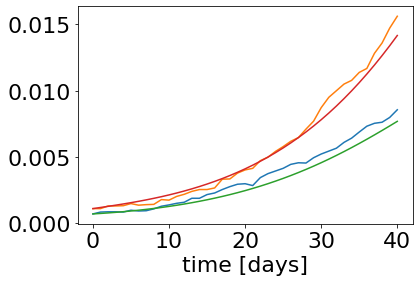

In [4]:
# load the data and rescale to intensive variables 
N_start = 20  
Tf_inference = 40 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps, rtol_det=1e-5, rtol_lyapunov=1e-5)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x) 
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)


time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.plot(obs[:, -2:])
plt.plot(np.einsum('ij,kj->ki', fltr, xm)[:, -2:])
plt.xlabel("time [days]")
plt.show()


### 2.1) Nested sampling

In [5]:
# Make parameter guesses (and define bounds for the MAP estimate later)
eps = 1e-5

param_priors = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 50]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 50]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 50]
    },
    'gE':{
        'mean': 0.1, 
        'std': 0.05, 
        'bounds': [eps, 50]
    }
}

fsa_g = 0.8 # not inferred 

E0_g = x0[M:2*M]
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.01/N, 1000/N], M).reshape(M, 2)

Ia0_g = x0[2*M:3*M]
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.01/N, 1000/N], M).reshape(M, 2)

init_fltr = np.repeat([False, True, True, False], M)
init_priors = {
    'independent': {
        'fltr': init_fltr,
        'mean': [*E0_g, *Ia0_g],
        'std': [*E_std, *Ia_std],
        'bounds': [*bounds_for_E, *bounds_for_Ia]
    }
}

start_time = time.time()
sampler = estimator.latent_infer_nested_sampling(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix,  
                                                 tangent=True, verbose=True, nlive=150, nprocesses=4) 
end_time = time.time()
print(end_time - start_time)

result, samples = estimator.latent_infer_nested_sampling_process_result(sampler, obs, fltr, param_priors, init_priors, contactMatrix=contactMatrix)

2134it [02:49, 12.58it/s, +150 | bound: 28 | nc: 1 | ncall: 11884 | eff(%): 19.219 | loglstar:   -inf < 1211.445 <    inf | logz: 1199.121 +/-  0.373 | dlogz:  0.001 >  0.159]


171.22491002082825


In [6]:
print("Model log-evidence for SEIR (computed by nested sampling): ", result.logz[-1])

Model log-evidence for SEIR (computed by nested sampling):  1199.121376504192


### 2.2) Sequential Monte Carlo

In [7]:
evidence_prms = pyross.evidence.latent_get_parameters(estimator, obs, fltr, Tf_inference, param_priors, init_priors, 
                                                      contactMatrix=contactMatrix, tangent=True)

start_time = time.time()
logz_smc = pyross.evidence.evidence_smc(*evidence_prms, npopulation=150, mcmc_iter=50, nprocesses=4, 
                                        target_cess=0.93, save_samples=False, verbose=False)
end_time = time.time()
print(end_time - start_time)

Iteration 1: alpha = 1.318359375e-06, ESS = 139.5078039407867, CESS = 0.930052026271911, log_evidence = -0.1875027462610692
Iteration 2: alpha = 3.8726806640625e-06, ESS = 127.78784419543445, CESS = 0.9308675264316146, log_evidence = -0.3778444525368721
Iteration 3: alpha = 8.342742919921876e-06, ESS = 114.86270871955651, CESS = 0.9297487680475429, log_evidence = -0.5562766761522129
Iteration 4: alpha = 1.532721519470215e-05, ESS = 102.47576580170521, CESS = 0.9301129100884654, log_evidence = -0.7387647415723602
Iteration 5: alpha = 2.7331776916980744e-05, ESS = 92.59447253266467, CESS = 0.9303058534873655, log_evidence = -0.913464696476078
Iteration 6: alpha = 5.58426110073924e-05, ESS = 82.71921985881474, CESS = 0.9299682730233549, log_evidence = -0.9751732901095749
Iteration 7: alpha = 0.00010395464353496207, ESS = 139.40019381544124, CESS = 0.9293346254362748, log_evidence = -1.1205414968763479
Iteration 8: alpha = 0.00019566820554064174, ESS = 126.72085097420617, CESS = 0.93003866

In [8]:
print("Model log-evidence for SEIR (computed by SMC): ", logz_smc) 

Model log-evidence for SEIR (computed by SMC):  1199.4375002506445


### 2.3) Path sampling

In [9]:
evidence_prms = pyross.evidence.latent_get_parameters(estimator, obs, fltr, Tf_inference, param_priors, init_priors, 
                                                      contactMatrix=contactMatrix, tangent=True)
steps = np.linspace(0, 1, 26)[1:]**5  # Choose some intermediate steps.
start_time = time.time()
step_list, sampler_list = pyross.evidence.evidence_path_sampling(*evidence_prms, steps=steps, npopulation=25, mcmc_iter=500, 
                                                                 nprocesses=4, verbose=False)
end_time = time.time()
print(end_time - start_time)

step: 1.0240000000000002e-07 (1/25)
step: 3.2768000000000005e-06 (2/25)
step: 2.4883199999999996e-05 (3/25)
step: 0.00010485760000000002 (4/25)
step: 0.0003200000000000001 (5/25)
step: 0.0007962623999999999 (6/25)
step: 0.0017210368000000007 (7/25)
step: 0.0033554432000000006 (8/25)
step: 0.006046617599999999 (9/25)
step: 0.010240000000000003 (10/25)
step: 0.0164916224 (11/25)
step: 0.025480396799999996 (12/25)
step: 0.038020403200000004 (13/25)
step: 0.05507317760000002 (14/25)
step: 0.07775999999999998 (15/25)
step: 0.10737418240000002 (16/25)
step: 0.14539335680000004 (17/25)
step: 0.19349176319999997 (18/25)
step: 0.2535525376 (19/25)
step: 0.3276800000000001 (20/25)
step: 0.4182119423999999 (21/25)
step: 0.5277319168 (22/25)
step: 0.6590815232000001 (23/25)
step: 0.8153726975999999 (24/25)
step: 1.0 (25/25)
1782.7933127880096


In [10]:
additional_steps = np.linspace(0, 0.2, 4)[1:]**4  # Add some more steps
step_list, sampler_list = pyross.evidence.evidence_path_sampling(*evidence_prms, steps=additional_steps, npopulation=25, mcmc_iter=500, 
                                                                 nprocesses=4, verbose=False, extend_step_list=step_list, 
                                                                 extend_sampler_list=sampler_list)

step: 1.9753086419753087e-05 (1/3)
step: 0.0003160493827160494 (2/3)
step: 0.0016000000000000003 (3/3)


In [11]:
logz_ps, logl_vals = pyross.evidence.evidence_path_sampling_process_result(*evidence_prms, step_list, sampler_list, nprocesses=4, burn_in=50)
print("Model log-evidence for SEIR (computed by path sampling): ", logz_ps) 

Model log-evidence for SEIR (computed by path sampling):  1197.8279540004007


### 2.4) Plot samples of the posterior, posterior mean and MAP estimate
We can use the result of nested sampling to get posterior samples.

In [12]:
map_params = estimator.latent_infer(obs, fltr, Tf_inference, param_priors, init_priors, contactMatrix=contactMatrix, tangent=True, 
                                    global_max_iter=200, local_max_iter=1000, global_atol=1.0, cma_population=50, verbose=True, ftol=1e-7) 


Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 8 (seed=1953902360, Wed Aug  5 20:16:08 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -1.190587539686511e+03 1.0e+00 9.21e-01  1e-04  9e-02 0:00.3
    2    100 -1.214634351141540e+03 1.3e+00 8.60e-01  1e-04  8e-02 0:00.5
    3    150 -1.181903103885473e+03 1.4e+00 9.65e-01  2e-04  9e-02 0:00.7
   16    800 -1.236840859167722e+03 5.8e+00 6.43e-01  1e-04  5e-02 0:03.9
   34   1700 -1.245624251561341e+03 1.3e+02 3.78e-01  7e-05  1e-02 0:08.0
   47   2350 -1.246541002434129e+03 4.8e+02 5.57e-01  1e-04  9e-03 0:11.1
Optimal value (global minimisation):  -1246.5410024341295
Starting local minimisation...
Optimal value (local minimisation):  -1246.8891962401335


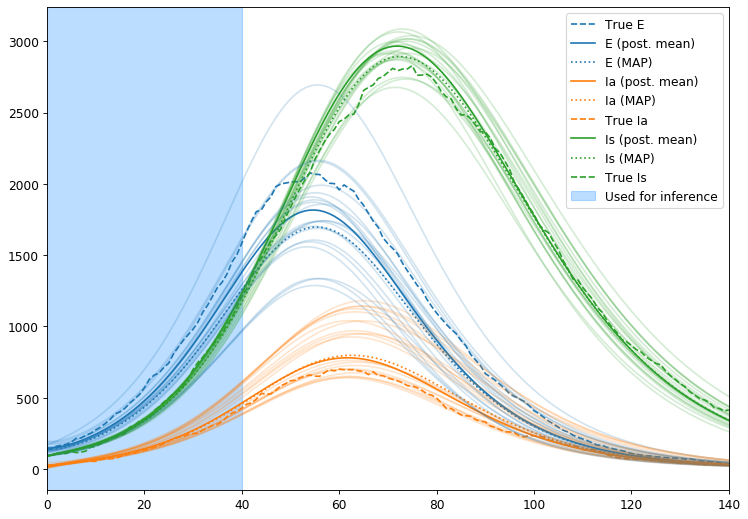

In [13]:
post_mean = pyross.utils.posterior_mean(samples)
estimator.set_params(post_mean['params_dict'])
estimator.set_det_model(post_mean['params_dict'])
x_pm = estimator.integrate(post_mean['x0'], N_start-1, Tf, Nf-N_start) * N
estimator.set_params(map_params['params_dict'])
estimator.set_det_model(map_params['params_dict'])
x_map = estimator.integrate(map_params['x0'], N_start-1, Tf, Nf-N_start) * N
x = np.load('latent_SEIR_traj.npy').astype('float')[N_start:]
fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x[:,M], label='True E', c="C0", linestyle='dashed')
plt.plot(x_pm[:, M], label='E (post. mean)', c="C0")
plt.plot(x_map[:, M], label='E (MAP)', c="C0", linestyle='dotted')
plt.plot(x_pm[:, 2*M], label='Ia (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Ia (MAP)', c="C1", linestyle='dotted')
plt.plot(x[:,2*M], label='True Ia', c="C1", linestyle='dashed')
plt.plot(np.sum(x_pm[:, 3*M:], axis=1), label='Is (post. mean)', c="C2")
plt.plot(np.sum(x_map[:, 3*M:], axis=1), label='Is (MAP)', c="C2", linestyle='dotted')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is', c="C2", linestyle='dashed')
for sample in pyross.utils.resample(samples, 20):
    estimator.set_params(sample['params_dict'])
    estimator.set_det_model(sample['params_dict'])
    x_det = estimator.integrate(sample['x0'], N_start-1, Tf, Nf-N_start) * N
    plt.plot(x_det[:, M], c="C0", alpha=0.2)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.2)
    plt.plot(np.sum(x_det[:, 3*M:], axis=1), c="C2", alpha=0.2)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()

## 3) Compute the model evidence for the SIR model
We take the same data points as in 2).

In [14]:
estimator2 = pyross.inference.SIR(parameters, M, fi, int(N), steps=4, rtol_det=1e-5, rtol_lyapunov=1e-5)
eps = 1e-5

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[N_start:N_start+Nf_inference]

fltr2=np.kron([[1, 1, 1], [0, 0, 1]], np.identity(M))
obs2=np.einsum('ij,kj->ki', fltr, x) 
x02=x[0]

param_priors2 = {
    'beta':{
        'mean': 0.02, 
        'std': 0.1,
        'bounds': [eps, 50]
    },
    'gIa':{
        'mean': 0.12, 
        'std': 0.1, 
        'bounds': [eps, 50]
    }, 
    'gIs':{
        'mean': 0.14, 
        'std': 0.05, 
        'bounds': [eps, 50]
    }
}
init_fltr2 = np.repeat([False, True, False], M)
init_priors2 = {
    'independent':{
        'fltr': init_fltr2, 
        'mean': [*Ia0_g], 
        'std': [*Ia_std], 
        'bounds': [*bounds_for_Ia]
    }
}

start_time = time.time()
# Here we only use nested sampling to compute the evidence because it is the fastest algorithm for this problem.
sampler2 = estimator2.latent_infer_nested_sampling(obs2, fltr2, Tf_inference, param_priors2, init_priors2, contactMatrix=contactMatrix,
                                                   tangent=True, verbose=True, nlive=150, nprocesses=4) 
end_time = time.time()
print(end_time - start_time)

result2, samples2 = estimator2.latent_infer_nested_sampling_process_result(sampler2, obs2, fltr2, param_priors2, init_priors2, 
                                                                           contactMatrix=contactMatrix)

1927it [01:19, 24.18it/s, +150 | bound: 25 | nc: 1 | ncall: 11195 | eff(%): 18.553 | loglstar:   -inf < 1207.413 <    inf | logz: 1196.467 +/-  0.223 | dlogz:  0.001 >  0.159]


80.51429295539856


In [15]:
print("Model log-evidence for SIR (computed by nested sampling): ", result2.logz[-1])

Model log-evidence for SIR (computed by nested sampling):  1196.4671535724901


In [16]:
ftol = 1e-9 # the relative tol in (-logp)  

params2 = estimator2.latent_infer(obs2, fltr2, Tf_inference, param_priors2, init_priors2, contactMatrix=contactMatrix,
                                  tangent=True, global_max_iter=200, local_max_iter=1000, global_atol=1.0, 
                                  cma_population=50, verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(25_w,50)-aCMA-ES (mu_w=14.0,w_1=14%) in dimension 5 (seed=1508732219, Wed Aug  5 20:17:45 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     50 -8.496240754158823e+02 1.0e+00 1.19e+00  2e-04  1e-01 0:00.3
    2    100 -1.181484298024278e+03 1.6e+00 1.12e+00  2e-04  1e-01 0:00.5
    3    150 -1.205311567438328e+03 1.8e+00 1.15e+00  2e-04  1e-01 0:00.7
   17    850 -1.161425300982979e+03 3.7e+00 8.92e-01  1e-04  7e-02 0:03.9
   36   1800 -1.227387440488096e+03 4.6e+02 7.06e-01  1e-04  1e-02 0:08.1
   41   2050 -1.227429588377177e+03 1.0e+03 6.32e-01  8e-05  5e-03 0:09.2
Optimal value (global minimisation):  -1227.4295883771765
Starting local minimisation...
Optimal value (local minimisation):  -1227.4352287778122
92.23868799209595


### 3.1) Plot samples of the posterior, posterior mean and MAP estimate

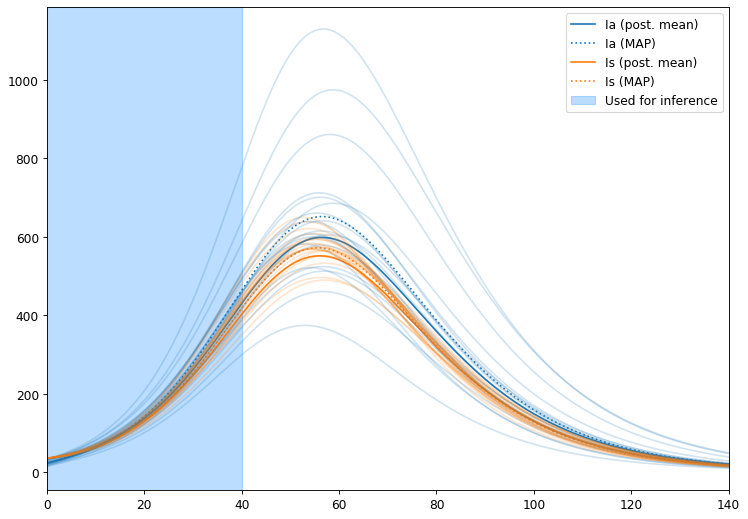

In [17]:
post_mean = pyross.utils.posterior_mean(samples2)
estimator2.set_params(post_mean['params_dict'])
estimator2.set_det_model(post_mean['params_dict'])
x_pm = estimator2.integrate(post_mean['x0'], N_start-1, Tf, Nf-N_start) * N
estimator2.set_params(params2['params_dict'])
estimator2.set_det_model(params2['params_dict'])
x_map = estimator2.integrate(params2['x0'], N_start-1, Tf, Nf-N_start) * N

fig = plt.figure(num=None, figsize=(11, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 11})
plt.plot(x_pm[:, M], label='Ia (post. mean)', c="C0")
plt.plot(x_map[:, M], label='Ia (MAP)', c="C0", linestyle='dotted')
plt.plot(x_pm[:, 2*M], label='Is (post. mean)', c="C1")
plt.plot(x_map[:, 2*M], label='Is (MAP)', c="C1", linestyle='dotted')
for sample in pyross.utils.resample(samples2, 20):
    estimator2.set_params(sample['params_dict'])
    estimator2.set_det_model(sample['params_dict'])
    x_det = estimator2.integrate(sample['x0'], N_start-1, Tf, Nf-N_start) * N
    plt.plot(x_det[:, M], c="C0", alpha=0.2)
    plt.plot(x_det[:, 2*M], c="C1", alpha=0.2)

plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf-N_start])
plt.legend()
plt.show()